In [127]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import s2spy.time
import s2spy.rgdr
from s2spy import RGDR
from s2spy.rgdr import utils
from sklearn.model_selection import ShuffleSplit
import s2spy.traintest
import re
import matplotlib as mpl
import pandas as pd
from copy import deepcopy

file_path = '../s2spy/tests/test_rgdr/test_data'
field = xr.open_dataset(f'{file_path}/sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc')
target_data = xr.open_dataset(f'{file_path}/tf5_nc5_dendo_80d77.nc').sel(cluster=3)

cal = s2spy.time.AdventCalendar((8, 31), freq = "30d")
cal = cal.map_to_data(field)
field_resampled = s2spy.time.resample(cal, field)
target_resampled = s2spy.time.resample(cal, target_data)

In [43]:
precursor = field_resampled.isel(i_interval=0)
target = target_resampled.isel(i_interval=7)

In [44]:
seed = 1 #same 'randomness'
n_splits = 4

shufflesplit = ShuffleSplit(n_splits=n_splits, test_size=0.25, random_state = seed)
cv = s2spy.traintest.TrainTestSplit(shufflesplit)

In [45]:
target_timeseries_splits = []
precursor_field_splits = []
for x_train, x_test, y_train, y_test in cv.split(precursor, y=target):
    target_timeseries_splits.append(target.sel(anchor_year=x_train.anchor_year.values).ts)
    precursor_field_splits.append(precursor.sel(anchor_year=x_train.anchor_year.values).sst)

In [48]:
rgdr = RGDR(eps_km=800, alpha=0.10, min_area_km2=0)

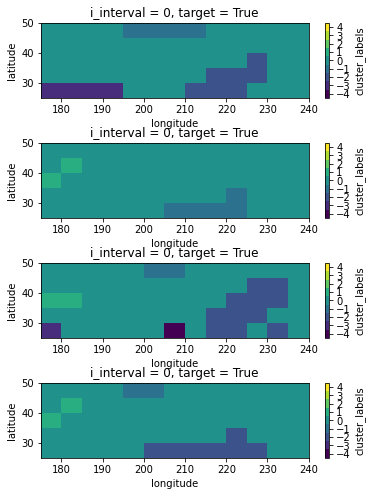

In [49]:
fig, axs = plt.subplots(
    ncols=1,
    nrows=n_splits,
    figsize=(6, 2*n_splits),
    gridspec_kw={'hspace':0.6}
)

for split in range(n_splits):
    _ = rgdr.preview_clusters(
        precursor_field_splits[split],
        target_timeseries_splits[split], 
        ax=axs[split],
        cmap='viridis',
        vmin=-4,
        vmax=4
    )

In [50]:
for split in range(n_splits):
    # do rgdr clustering for every split
    clusters = rgdr.get_clusters(precursor_field_splits[split], target_timeseries_splits[split])
    clusters = utils.cluster_labels_to_ints(clusters)
    
    rgdr_out = rgdr.fit_transform(precursor_field_splits[split], target_timeseries_splits[split])
    #create new array of only the cluster labels with dimension split
    if split == 0:
        cluster_labels = clusters.cluster_labels.expand_dims({'split':1})
        rgdr_output = rgdr_out.expand_dims({"split": 1})
    else:
        cluster_labels = xr.concat([cluster_labels,clusters.cluster_labels],'split')
        rgdr_output = xr.concat([rgdr_output, rgdr_out], "split")

In [51]:
from s2spy.rgdr import label_alignment

overlap_df = label_alignment.overlap_labels(cluster_labels)
overlap_df = overlap_df.drop(columns='label_cell_count')
overlap_df

split          0                        1              2                       \
label         -3        -2   -1        -1    1        -4    -3        -2   -1   
split label                                                                     
0     -3     NaN       NaN  NaN  0.000000  NaN  0.000000  0.25  0.000000  0.0   
      -2     NaN       NaN  NaN  0.571429  NaN  0.000000  0.00  0.857143  0.0   
      -1     NaN       NaN  NaN  0.000000  NaN  0.000000  0.00  0.000000  0.5   
1     -1     0.0  0.800000  0.0       NaN  NaN  0.200000  0.00  0.600000  0.0   
       1     NaN       NaN  NaN       NaN  NaN       NaN   NaN       NaN  NaN   
2     -4     0.0  0.000000  0.0  1.000000  NaN       NaN   NaN       NaN  NaN   
      -3     1.0  0.000000  0.0  0.000000  NaN       NaN   NaN       NaN  NaN   
      -2     0.0  0.545455  0.0  0.272727  NaN       NaN   NaN       NaN  NaN   
      -1     0.0  0.000000  1.0  0.000000  NaN       NaN   NaN       NaN  NaN   
       1     NaN       NaN  NaN       NaN  0.5       NaN   NaN       NaN  NaN   
3     -2     0.0  0.571429  0.0  0.714286  NaN  0.142857  0.00  0.428571  0.0   
      -1     0.0  0.000000  1.0  0.000000  NaN  0.000000  0.00  0.000000  0.5   
       1     NaN       NaN  NaN       NaN  1.0       NaN   NaN       NaN  NaN   

split                    3            
label          1        -2   -1    1  
split label                           
0     -3     NaN  0.000000  0.0  NaN  
      -2     NaN  0.571429  0.0  NaN  
      -1     NaN  0.000000  0.5  NaN  
1     -1     NaN  1.000000  0.0  NaN  
       1     0.5       NaN  NaN  1.0  
2     -4     NaN  1.000000  0.0  NaN  
      -3     NaN  0.000000  0.0  NaN  
      -2     NaN  0.272727  0.0  NaN  
      -1     NaN  0.000000  0.5  NaN  
       1     NaN       NaN  NaN  0.5  
3     -2     NaN       NaN  NaN  NaN  
      -1     NaN       NaN  NaN  NaN  
       1     0.5       NaN  NaN  NaN

In [148]:
from typing import Set
import string

def get_overlapping_clusters(cluster_labels, min_overlap: float = 0.1):
    overlap_df = label_alignment.overlap_labels(cluster_labels)
    overlap_df = overlap_df.drop(columns='label_cell_count')
    overlap_df.columns = [
        '_'.join([str(el) for el in col]) for col in overlap_df.columns.values
        ]  # type: ignore
    overlap_df.index = [
        '_'.join([str(el) for el in idx]) for idx in overlap_df.index.values
        ]  # type: ignore

    clusters = set()
    for row in range(overlap_df.index.size): # type: ignore
        overlapping = overlap_df.iloc[row].where(overlap_df.iloc[row] > min_overlap).dropna()
        cluster = set(overlapping.index)
        cluster.add(overlap_df.iloc[row].name)
        clusters.add(frozenset(cluster))

    return clusters

def remove_subsets(clusters: Set):
    no_subsets = set(clusters)
    for cluster in clusters:
        no_subsets.remove(cluster)
        if not any(cluster.issubset(cl) for cl in no_subsets):
            no_subsets.add(cluster)
    return no_subsets

def remove_overlapping_clusters(clusters: Set):
    clusterlist = [set(cl) for cl in clusters]
    clusterlist.sort(key=len)
    sanitised_clusters = []
    for _ in range(len(clusterlist)):
        cluster = clusterlist.pop(0)
        [cluster.difference_update(cl) for cl in clusterlist]
        sanitised_clusters.append(cluster)
    return {frozenset(cluster) for cluster in sanitised_clusters}

def name_clusters(clusters: Set):
    #Ensure a sufficiently long list of possible names
    cluster_names = list(string.ascii_uppercase) + list(string.ascii_lowercase) 

    named_clusters = {}
    for cluster in clusters:
        name = cluster_names.pop(0)
        named_clusters[name] = set(cluster)
        
    return named_clusters

def create_renaming_dict(aligned_clusters):
    inversed_names = {}
    for key in aligned_clusters:
        for el in aligned_clusters[key]:
            inversed_names[el] = key

    renaming_dict = {}
    for key in inversed_names:
        ky = key.split('_')
        split = int(ky[0])
        cluster = int(ky[1])
        if split in renaming_dict:
            apd = renaming_dict[split] + [(cluster, inversed_names[key])]
            renaming_dict[split] = apd
        else:
            renaming_dict[split] = [(cluster, inversed_names[key])]
    return renaming_dict

def ensure_unique_names(renaming_dict: dict):
    """This function ensures that in every split, every cluster has a unique name.
    
    The function finds the non-unqiue names within each split, and will rename these by
    adding a number. For example, there are three clusters in the first split with the
    name "C". The new names will be "C", "C1" and "C2".
    
    Args:
        renaming_dict: Renaming dictionary with non unique names.
    
    returns:
        Renaming dictionary with only unique names
    """
    renamed_dict = deepcopy(renaming_dict)
    for split in renamed_dict:
        cluster_old_names = [cl for cl, _ in renamed_dict[split]]
        cluster_new_names = [cl for _, cl in renamed_dict[split]]
        
        double_names = [x if cluster_new_names.count(x)>1 else None for x in set(cluster_new_names)]
        double_names = list(np.array(double_names)[np.array(double_names) != None])

        zero_names = []
        for double_name in double_names:
            ndouble = cluster_new_names.count(double_name)
            for i in range(ndouble):
                el = cluster_new_names.index(double_name)
                cluster_new_names[el] = double_name + str(i)  # type: ignore
                if i == 0:
                    zero_names.append(double_name + str(i))
        # Re-rename the "name0" cluster to "name"
        for name in zero_names:
            cluster_new_names[cluster_new_names.index(name)] = name.replace("0","")
        renamed_dict[split] = list(zip(cluster_old_names, cluster_new_names))
    return renamed_dict

In [149]:
aligned_clusters = get_overlapping_clusters(cluster_labels, min_overlap=0.01)
aligned_clusters = remove_subsets(aligned_clusters)
aligned_clusters = remove_overlapping_clusters(aligned_clusters)
aligned_clusters = name_clusters(aligned_clusters)
aligned_clusters

{'A': {'1_1', '2_1', '3_1'},
 'B': {'0_-3', '2_-3'},
 'C': {'0_-2', '1_-1', '2_-2', '2_-4', '3_-2'},
 'D': {'0_-1', '2_-1', '3_-1'}}

In [150]:
renaming_dict = create_renaming_dict(aligned_clusters)
renaming_dict = ensure_unique_names(renaming_dict)
renaming_dict

{1: [(1, 'A'), (-1, 'C')],
 3: [(1, 'A'), (-2, 'C'), (-1, 'D')],
 2: [(1, 'A'), (-3, 'B'), (-2, 'C'), (-4, 'C1'), (-1, 'D')],
 0: [(-3, 'B'), (-2, 'C'), (-1, 'D')]}

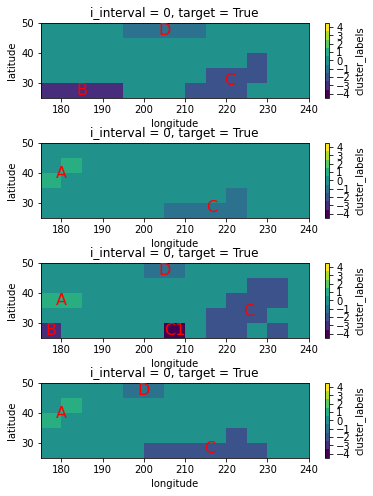

In [144]:
fig, axs = plt.subplots(
    ncols=1,
    nrows=n_splits,
    figsize=(6, 2*n_splits),
    gridspec_kw={'hspace':0.6}
)

for split in range(n_splits):
    _ = rgdr.preview_clusters(
        precursor_field_splits[split],
        target_timeseries_splits[split], 
        ax=axs[split],
        cmap='viridis',
        vmin=-4,
        vmax=4
    )
    for cl in renaming_dict[split]:
        cluster = rgdr_output.isel(split=split).sel(cluster_labels=f"lag:0_cluster:{cl[0]}")
        axs[split].text(x=cluster.longitude, y=cluster.latitude, s=cl[1], fontsize=16, va='center', ha='center',c="red")


In [135]:
renamed = []
for split in range(n_splits):
    rgdr_split = rgdr_output.isel(split=split)
    labels = rgdr_split['cluster_labels'].values
    for cl in renaming_dict[split]:
        if f"lag:0_cluster:{cl[0]}" not in labels:
            break
        labels[labels==f"lag:0_cluster:{cl[0]}"] = cl[1]
    rgdr_split['cluster_labels'] = labels
    renamed.append(rgdr_split)
rgdr_aligned = xr.concat(renamed, "split")
rgdr_aligned = rgdr_aligned.dropna(dim='cluster_labels', how='all')

In [153]:
non_dim_coords = list(rgdr_aligned.isel(split=0).coords)[2:]
split_dataframes = []
for split in range(n_splits):
    split_dataframes.append(
        rgdr_aligned.isel(split=split).to_pandas().dropna(how='all')
    )

In [161]:
split_dataframes[0].head()

cluster_labels,A,B,C
anchor_year,,,
1980,289.704106,296.362443,NaN
1981,289.914271,294.638110,NaN
1984,289.568641,295.076624,NaN
1985,289.573436,296.090116,NaN
1986,290.288245,295.571885,NaN


In [159]:
split_dataframes[2].head()

cluster_labels,A,B,C
anchor_year,,,
1980,NaN,295.105126,297.488609
1981,NaN,293.525182,297.666622
1982,NaN,294.420667,297.667070
1983,NaN,294.653440,297.327217
1984,NaN,293.627068,299.020338
